In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch

### Data

In [2]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [3]:
time_series = sm.datasets.sunspots.load_pandas().data

time_series.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del time_series["YEAR"]

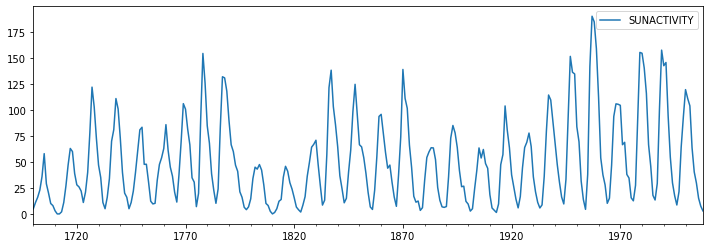

In [4]:
time_series.plot(figsize=(12,4));

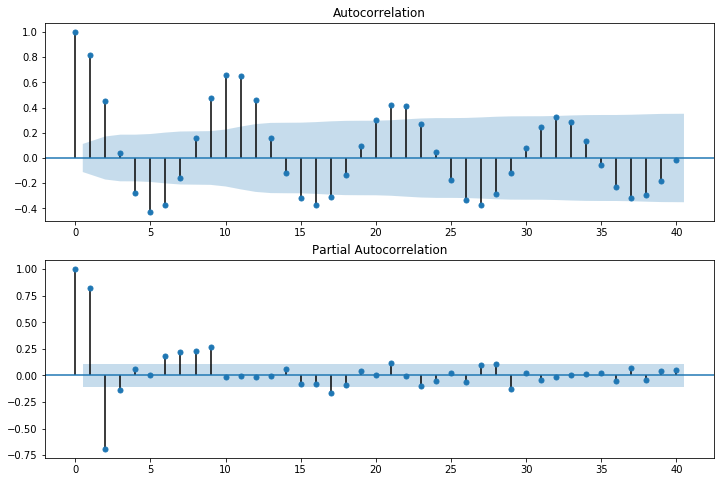

In [5]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(time_series.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(time_series, lags=40, ax=ax2)

### Arima

Test MSE: 417.509


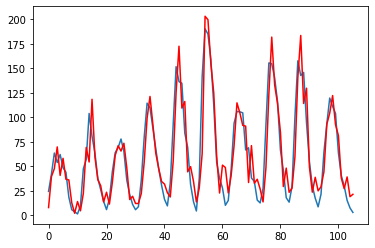

In [6]:
X = time_series.values
train_size = int(len(X) * 0.66)
train, test = list(X[0:train_size]), X[train_size:len(X)]
predictions = []
for observarion in test:
    model = sm.tsa.ARIMA(train, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    train.append(observarion)

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

### LSTM

In [7]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [8]:
X = time_series.values
train_size = int(len(X) * 0.66)
train, test = list(X[0:train_size]), X[train_size:len(X)]

In [9]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [10]:
seq_length = 5

x, y = sliding_windows(X, seq_length)

train_size = int(len(y) * 0.66)
test_size = len(y) - train_size

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))

In [11]:
num_epochs = 5000
learning_rate = 0.01

input_size = 1
hidden_size = 200
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 3150.48633
Epoch: 1000, loss: 1.22166
Epoch: 2000, loss: 0.01698
Epoch: 3000, loss: 0.00819
Epoch: 4000, loss: 0.05900


Test MSE: 513.707


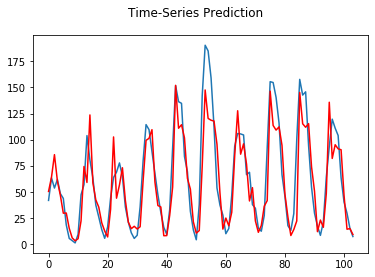

In [12]:
lstm.eval()
predictions = lstm(testX).detach().numpy()

error = mean_squared_error(testY, predictions)
print('Test MSE: %.3f' % error)

plt.plot(testY)
plt.plot(predictions, color='red')
plt.suptitle('Time-Series Prediction')
plt.show()

### References

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/statespace_arma_0.ipynb

https://github.com/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb
